# Imports

In [2]:
import requests
import json
from bs4 import BeautifulSoup
import networkx as nx
import re
from matplotlib import pyplot as plt
import time
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict

# Load statics

In [3]:
# Load stored course-site HTMLs
with open('valid_courses.json') as f:
    valid_courses = json.load(f)

# Load department color mapping
with open('department_colors.json') as f:
    department_colors = json.load(f)

# Load department names
with open('department_names.json') as f:
    department_names = json.load(f)

# Create graph

## Add nodes

In [4]:
# Initialize directd graph
G = nx.DiGraph()

# Go through each course
for course_num in valid_courses:
    department = course_num[:2] 
    G.add_node(course_num,
               course_num=course_num,
               page=valid_courses[course_num],
               department=department, 
               color=department_colors[department],
               department_name=department_names[department])

## Add edges

In [5]:
for course_num in valid_courses:

    ### Initialize BeuatifulSoup object
    page = G.nodes[course_num]['page']
    soup = BeautifulSoup(page, 'html.parser')

    ### Find <tr> that contains "Academic prerequisites"
    search_string = "Academic prerequisites"
    
    # Find respective label
    label = soup.find('label', string=re.compile(search_string))
    if label is None:
        continue
    
    # Get element that contains the label + prerequisites
    parent = label.find_parent().find_parent()
    
    # Get second <td>
    prerequisite = parent.find_all('td')[1].text

    # Remove whitespace and breaks (\n and \r)
    prerequisite  = prerequisite.replace('\r', ' ')
    prerequisite  = prerequisite.replace('\n ', '')

    # Extract 5 digit numbers (any course number)
    prerequisites = set(re.findall(r'\d{5}', prerequisite))
    
    # if course exists in graph, add edge
    for prerequisite in prerequisites:
        if prerequisite in G.nodes:
            if prerequisite == course_num: 
                # Handle self-loops
                pass
            else:
                G.add_edge(prerequisite, course_num)

## Add text attributes

In [6]:
for node in G.nodes:
    
    ### Initialize BeuatifulSoup object
    page = G.nodes[node]['page']
    soup = BeautifulSoup(page, 'html.parser')
    
    ### Add title to node
    title = soup.title.text
    cleaned = ' '.join(title.strip().split())[6:]
    G.nodes[node]['course_title'] = cleaned
    
    ### Add course text to node (General course objectives + Learning objectives + Content)
    div = soup.find('div', string=re.compile("General course objectives")).parent(string=True)
    
    remove_indeces = []
    for d, text in enumerate(div):
        if text in ["General course objectives", "Learning objectives", "Content", "Last updated", "\r\nA student who has met the objectives of the course will be able to:\r\n\r\n"]:
            remove_indeces.append(d)
    
    new_div = [div[i] for i in range(len(div)) if i not in remove_indeces]
    text = ' '.join(new_div[:-1]).replace('\r', ' ').replace('\n', '')
    cleaned = ' '.join(text.strip().split())
    G.nodes[node]['course_text'] = cleaned  
    G.nodes[node]['text_size'] = len(cleaned) 
    G.nodes[node]['word_count'] = len(cleaned.split())

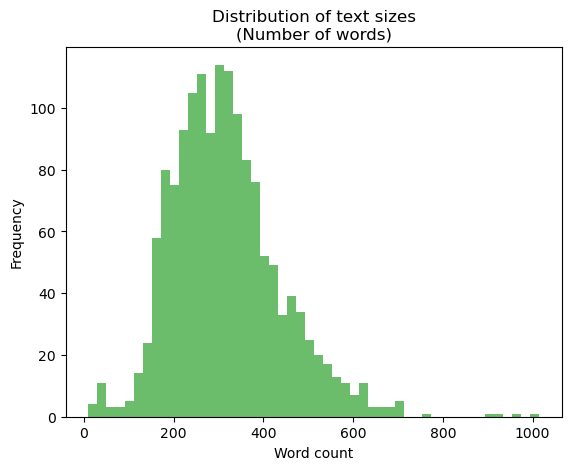

In [7]:
# plot distribution of text sizes
text_sizes = [G.nodes[node]['word_count'] for node in G.nodes]
plt.hist(text_sizes, bins=50, color='C2', alpha=0.7)
plt.title('Distribution of text sizes\n(Number of words)')
plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.show()

# Get evaluations and grades

In [8]:
# Evaluations
with open('eval_scores.json') as f:
    eval_scores = json.load(f)

# Grades
with open('grade_scores.json') as f:
    grade_scores = json.load(f)

In [20]:
# Apply evaluation and grade attributes
for course_num in grade_scores:
    G.nodes[course_num]['eval_scores'] = eval_scores[course_num]
    G.nodes[course_num]['grade_scores'] = grade_scores[course_num]
    
# Remove nodes from G that do not have evaluation scores
G = G.subgraph([node for node in G.nodes if 'eval_scores' in G.nodes[node]])

In [10]:
G.nodes['02805']

{'course_num': '02805',
 'page': '<!DOCTYPE html>\r\n<html>\r\n<head>\r\n    <meta http-equiv="X-UA-Compatible" content="IE=edge" />\r\n    <meta charset="utf-8" />\r\n    <meta name="viewport" content="width=device-width, initial-scale=1.0">\r\n    \r\n    <title>\r\n    02805 Social graphs and interactions \r\n</title>\r\n    <link href="/bundles_css_general?v=mCt0xLH6ZVm097AMT4IZXI_8YhGCBjBIv-CzzPZWduw1" rel="stylesheet"/>\r\n\r\n    <script src="/bundles_js_general?v=m944kgjFG7-r2HFwxi7Q_xDuvGXt8MWkcxYxVH_TSmE1"></script>\r\n\r\n    \r\n\r\n\r\n    <script>\r\n        $(function () {\r\n            $("[data-open-dialog]").on(\'click touchstart\', function () {\r\n                var me = $(this);\r\n                var bs = $("#" + me.data("open-dialog"));\r\n                bs.modal({ show: true, backdrop: true });\r\n            });\r\n        });\r\n\r\n        function getCookie(cname) {\r\n            var name = cname + "=";\r\n            var decodedCookie = decodeURIComponen

# Degree distribution

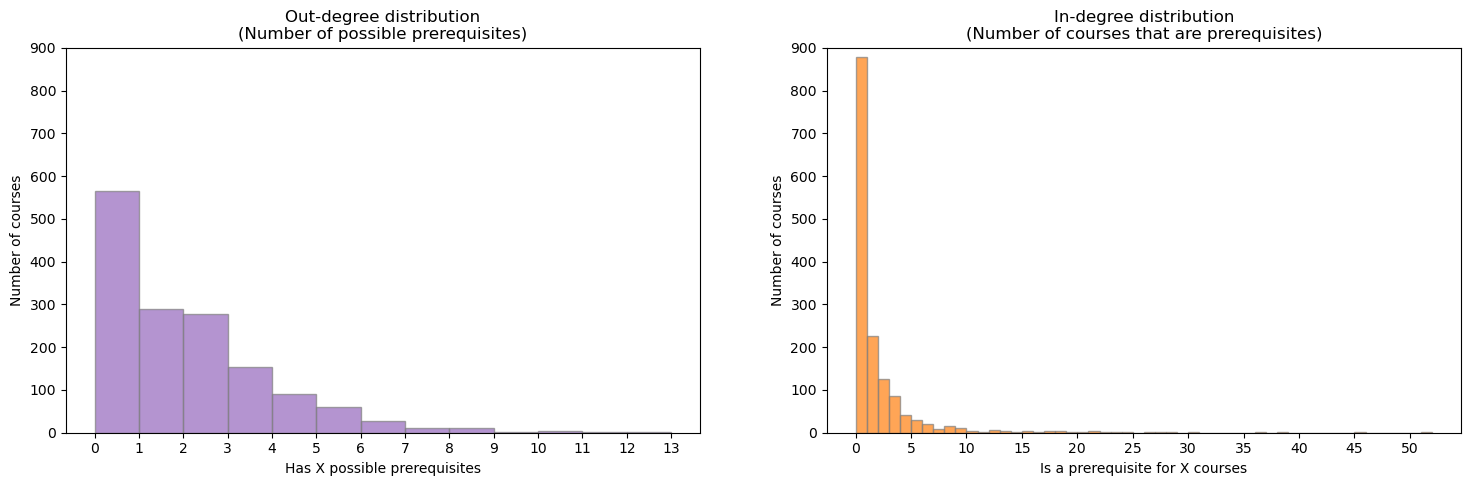

In [11]:
# Calculate in- and out-degrees. Show histogram
in_degrees = [G.in_degree(n) for n in G.nodes]
out_degrees = [G.out_degree(n) for n in G.nodes]

fig, axs = plt.subplots(1, 2, figsize=(18, 5))
axs[0].set_ylim(0, 900)
axs[0].hist(in_degrees, bins=range(min(in_degrees), max(in_degrees) + 2), color='C4', alpha=0.7, edgecolor='grey', label='In-degree (is a prerequisite)')
axs[0].set_xlabel('Has X possible prerequisites')
axs[0].set_ylabel('Number of courses')
axs[0].set_title('Out-degree distribution\n(Number of possible prerequisites)')
axs[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axs[0].xaxis.set_major_locator(plt.MultipleLocator(1))

axs[1].set_ylim(0, 900)
axs[1].hist(out_degrees, bins=range(min(out_degrees), max(out_degrees) + 2), color='C1', alpha=0.7, edgecolor='grey', label='Out-degree (number of possible prerequisites)')

axs[1].set_xlabel('Is a prerequisite for X courses')
axs[1].set_ylabel('Number of courses')
axs[1].set_title('In-degree distribution\n(Number of courses that are prerequisites)')
axs[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axs[1].xaxis.set_major_locator(plt.MultipleLocator(5))

plt.show()

# Plotting

## Test partitionings

### Label propagation (overlapping communities)

In [ ]:
import networkx as nx
from collections import Counter, defaultdict
import random

def overlapping_label_propagation(graph, max_size, max_iterations=100):
    """
    Overlapping Label Propagation Algorithm with size constraints.

    Parameters:
        graph (nx.Graph): The input graph.
        max_size (int): The maximum allowable size for a community.
        max_iterations (int): Maximum number of iterations to run the algorithm.

    Returns:
        dict: A dictionary where keys are community indices (starting from 0) and values are lists of nodes.
    """
    # Initialize each node with its own unique label as a set
    labels = {node: {node} for node in graph.nodes}
    
    for iteration in range(max_iterations):
        changes = False
        
        # Randomize node order to reduce bias
        nodes = list(graph.nodes)
        random.shuffle(nodes)
        
        for node in nodes:
            # Collect all labels from neighbors
            neighbor_labels = []
            for neighbor in graph.neighbors(node):
                neighbor_labels.extend(labels[neighbor])  # Collect labels of neighbors
            
            # Count the frequency of each label in the neighborhood
            label_counts = Counter(neighbor_labels)
            
            # Sort labels by frequency (descending) and resolve ties randomly
            sorted_labels = sorted(label_counts.items(), key=lambda x: (-x[1], random.random()))
            
            # Add labels while respecting size constraints
            current_labels = labels[node]
            for label, _ in sorted_labels:
                community_size = sum(1 for n in graph.nodes if label in labels[n])
                if community_size < max_size and label not in current_labels:
                    current_labels.add(label)
                    changes = True
            
        # Stop if no labels were changed
        if not changes:
            break
    
    # Create a community dictionary with sequential indices
    community_dict = defaultdict(list)
    label_to_index = {}  # Map original labels to indices
    current_index = 0
    
    for node, node_labels in labels.items():
        for label in node_labels:
            if label not in label_to_index:
                label_to_index[label] = current_index
                current_index += 1
            community_dict[label_to_index[label]].append(node)
    
    return dict(community_dict)



In [65]:
# Label propagation for overlapping communities
from networkx.algorithms.community import label_propagation_communities

H = G.to_undirected()

# communities = label_propagation_communities(H)
communities = overlapping_label_propagation(H, 6)


In [66]:
communities

{0: ['01001', '01002', '01034', '01037', '01617', '01622'],
 1: ['01001', '01002', '41501', '41516', '46420', '46440'],
 2: ['01001', '01002', '41501', '41516', '46411', '46420'],
 3: ['01001', '01002', '02393', '02504', '02561', '02566'],
 4: ['01001', '01002', '02393', '02561', '41312', '41320'],
 5: ['01001', '01002', '41501', '41516', '46411', '46420'],
 6: ['01001', '30101', '30102', '41312', '41320', '46211'],
 7: ['01001', '01002', '10346', '41292', '41317', '46115'],
 8: ['01001', '01002', '22475', '41501', '41516', '41737'],
 9: ['01001', '01002', '02393', '02561', '02563', '41312'],
 10: ['01001', '34229', '34302', '41312', '41320', '46211'],
 11: ['01001', '01003', '02586', '10037', '26020', '26022'],
 12: ['01001', '01018', '01405', '30300', '30310', '34251'],
 13: ['01001', '01002', '26021', '47305', '47310', '47514'],
 14: ['01001', '01002', '01237', '01238', '41312', '41320'],
 15: ['01002', '01003', '01237', '02586', '10037', '26022'],
 16: ['01002', '02249', '02405', '

In [84]:
_communities = defaultdict(list)
for community in communities:
    for node in communities[community]:
        _communities[community].append(H.nodes[node]['course_num'])

_communities.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [85]:
_communities[11]

['01001', '01003', '02586', '10037', '26020', '26022']

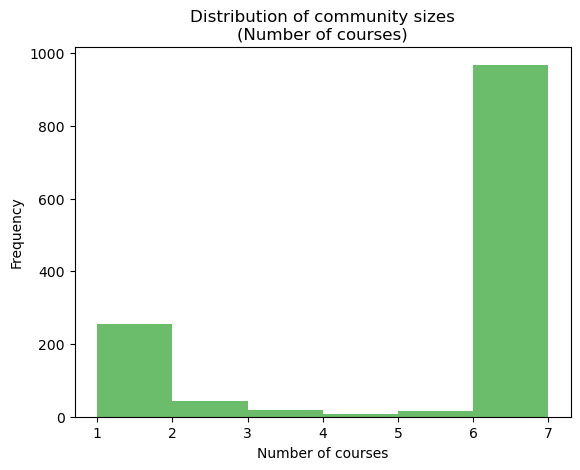

In [79]:
# plot distribution of value sizes
value_sizes = [len(_communities[c]) for c in _communities]
plt.hist(value_sizes, bins=range(min(value_sizes), max(value_sizes) + 2), color='C2', alpha=0.7)
plt.title('Distribution of community sizes\n(Number of courses)')
plt.xlabel('Number of courses')
plt.ylabel('Frequency')
plt.show()

In [80]:
G.number_of_nodes(), H.number_of_nodes()

(1307, 1307)

In [83]:
_communities[0]

['Mathematics 1a (Polytechnical foundation)',
 'Mathematics 1b (Polytechnical Foundation)',
 'Advanced Engineering Mathematics 2',
 'Advanced Engineering Mathematics 2 (Summer University)',
 'Introduction to Dynamical Systems',
 'Advanced Dynamical Systems: Applications in Science and Engineering']

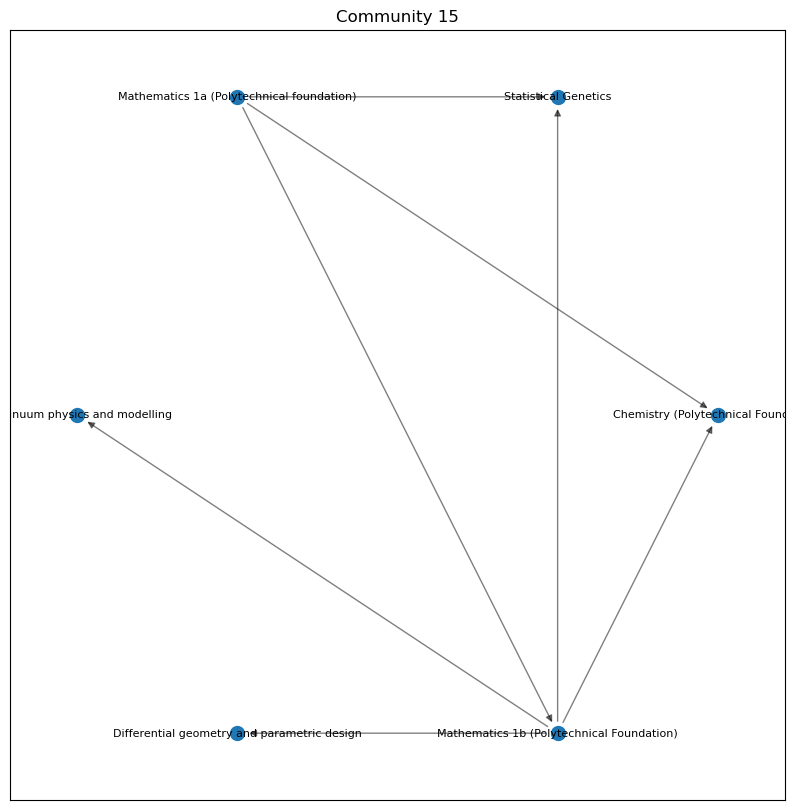

In [97]:
# plot subgraph of G belong to community X
index = 15
subgraph = G.subgraph(_communities[index])
pos = nx.circular_layout(subgraph)
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(subgraph, pos, node_size=100, node_color='C0')
nx.draw_networkx_edges(subgraph, pos, alpha=0.5)
# labels = course_title
nx.draw_networkx_labels(subgraph, pos, labels={node: G.nodes[node]['course_title'] for node in subgraph.nodes}, font_size=8)

plt.title(f'Community {index}')
plt.show()

### Department only

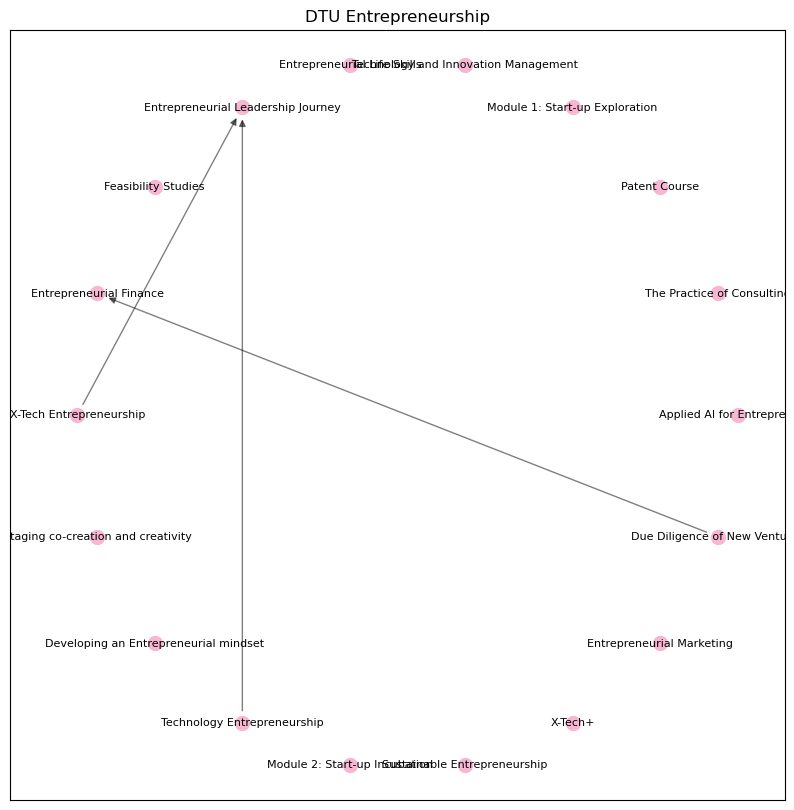

In [116]:
# plot subgraph of G, where department is X
department = '38'
subgraph = G.subgraph([node for node in G.nodes if G.nodes[node]['department'] == department])
pos = nx.circular_layout(subgraph)
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(subgraph, pos, node_size=100, node_color=department_colors[department])
nx.draw_networkx_edges(subgraph, pos, alpha=0.5)
# labels = course_title
nx.draw_networkx_labels(subgraph, pos, labels={node: G.nodes[node]['course_title'] for node in subgraph.nodes}, font_size=8)
plt.title(department_names[department])
plt.show()

# Summarize communities

## Grades

## Evaluations

## Text